# 5. The Value of Domain Knowledge
Compiled by [Morgan Williams](mailto:morgan.williams@csiro.au) for C3DIS 2018 

Thus far, much of the content has concerned more applied chemistry and statistics. Here we touch on some valuable aspects of domain-specific knowledge relevant for geochemical data analysis. Additionally, we examine the potential for data to be used as a validation method for existing domain methods and knowledge.

### Classification

*"All science is either physics or stamp collecting"* **Ernest Rutherford**

Geologists, like most other scientists which conduct observation-based investigations, have a habit of 'stamp collecting'. Methods to classify rocks provide geologists with a vocabulary with which to discuss and focus their investigations, but models developed in the past are rarely subjected to continued testing and refinement. Geological samples and derived geochemical data are commonly stored with pre-derived classifications. Here we derive these from their models, and compare i) the quality of database classification information, and ii) the potential relevance of historical classification models in an era which is no longer data-limited.

Modern databases provide a foundation for i) testing historical classification schemes and ii) implementing new classification schemes based on inherent data relationships and statistical divisions.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, './src')
from compositions import *
from geochem import *
from classification import Geochemistry
from alteration import *
from datasource import load_df
from normalisation import *
from pprint import pprint

In [3]:
%%memit
df = load_df('EarthChemData.pkl', dense=True)

peak memory: 1499.20 MiB, increment: 1390.16 MiB


In [4]:
cm = Geochemistry.TAS()
classnames = cm.clsf.fclasses + ['none']
df.TotalAlkali = df.Na2O + df.K2O
df['TAS'] = cm.classify(df).astype('category')
df['TAScolors'] = df['TAS'].map(lambda x: classnames.index(x)) # Use the index in the list for a simple colormap
df['TASRock'] = df['TAS'].map(lambda x: cm.clsf.fields.get(x,{'names': ['N/A']}).get('names')[0])

From here we can assess a range of questions regarding the data quality, and potentially the quality of classification methods.

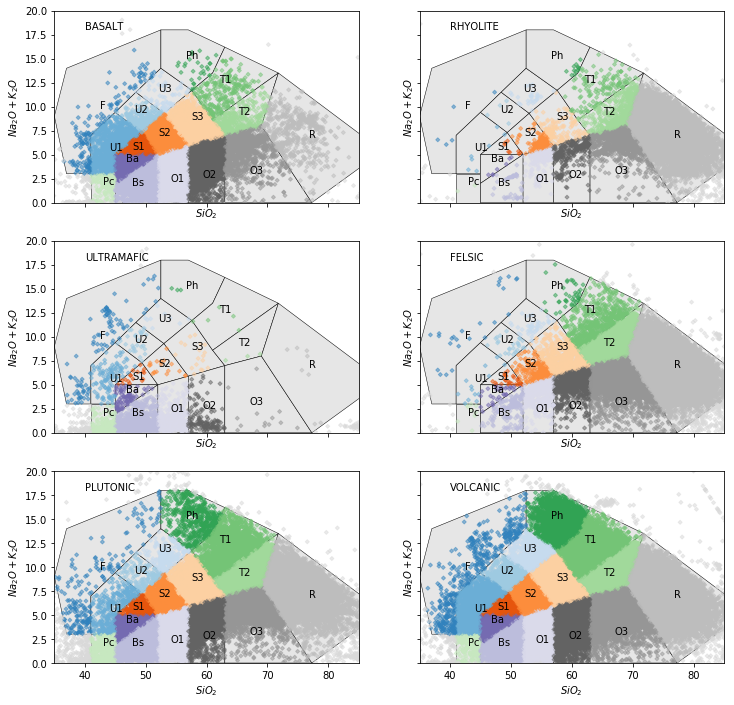

In [5]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True)
ax=ax.flat
for a in ax:
    a.set_ylabel('$Na_2O + K_2O$')
    a.set_xlabel('$SiO_2$')
    cm.add_to_axes(a, facecolor='0.9', edgecolor='k', linewidth=0.5, zorder=-1)

TAS_filter = (~pd.isnull(df.SiO2)) & (~pd.isnull(df.TotalAlkali)) & (df.loc[:, 'Material'] == 'IGNEOUS')
filters = []
for rockname in ['BASALT', 'RHYOLITE']:
    filters.append((rockname, TAS_filter & (df.loc[:, 'RockName'] == rockname)))
    
for composition in ['ULTRAMAFIC', 'FELSIC']:
    filters.append((composition, TAS_filter & (df.loc[:, 'Composition'] == composition)))
    
for rocktype in ['PLUTONIC', 'VOLCANIC']:
    filters.append((rocktype, TAS_filter & (df.loc[:, 'Type'] == rocktype))) 
    
for ix, (name, filt) in enumerate(filters):
    subdf = df.loc[filt, :]
    ax[ix].annotate(name, xy=(0.1, 0.9), ha='left', xycoords=ax[ix].transAxes)
    ax[ix].scatter(subdf.SiO2,
                   subdf.TotalAlkali,
                   c=subdf.TAScolors,
                   alpha=0.5, marker='D', s=8, cmap='tab20c')

### Give me a Map: Incorporating Reference Frames

Communicating the significance of data in a broader context requires some reference frame. This is a feature commonly addressed throughout all scientific disciplines, and geologists in general do this relatively well.

The simplest case of such a reference frame in geochemistry is the composition of a known reference material - which could be a mineral, a particular rock type or our estimate for the average composition of the solar system. While such reference frames are present throughout the literature, they are rarely baked into analysis tools, and the basic information required to reproduce them is commonly required to be reconstructed manually.

Here we attempt to begin construction of a few reference frames for different purposes. The first is general orientation - where do our compositions lie relative to others (e.g. mineral compositions, average compositions globally). To some extent, the classifications mentioned above can help with this. The second is to have a reference frame to illustrate the potential effects of a specific process (e.g. if I mixed two compositions, what would the range of expected compositions look like?).

#### Normalisation

In [6]:
refdb = build_reference_db(Path("./data/refcomp"), encoding='cp1252')
pprint(refdb)
CH = RefComp(Path("./data/refcomp/CH_PalmeONeill2014.csv"), encoding='cp1252')

n = 100
dat = pd.DataFrame({'Cu': 0.1 * (np.random.randn(n) * 1 + 5),
                   'Mn': np.linspace(0.001, 2, n),
                   'Fe': 0.98 ** np.linspace(0.001, 2, n),
                   'Ni': np.exp(np.linspace(0.001, 1, n))
                   })

print(CH['Cu', 'Mn'], CH.Cu, CH.Mn)
print(dat.loc[:3, :])
print(CH.normalize(dat).loc[:3, :])

{'Chondrite_PON': Model of Chondrite (Palme2014),
 'D-DMM_WH': Model of DepletedDepletedMORBMantle (Workman2005),
 'DMM_WH': Model of DepletedMORBMantle (Workman2005),
 'DM_SS': Model of DepletedMantle (Salters2004),
 'E-DMM_WH': Model of EnrichedDepletedMORBMantle (Workman2005),
 'PM_PON': Model of PrimitiveMantle (Palme2014)}
    value  unc_2sigma units
var                        
Cu    133       37.24   ppm
Mn   1916      229.92   ppm 133.0 1916.0
         Cu        Mn        Fe        Ni
0  0.596637  0.001000  0.999980  1.001001
1  0.492839  0.021192  0.999572  1.011153
2  0.419957  0.041384  0.999164  1.021408
3  0.602454  0.061576  0.998757  1.031767
         Cu            Mn        Fe        Ni
0  0.004486  5.219207e-07  0.000005  0.000092
1  0.003706  1.106050e-05  0.000005  0.000093
2  0.003158  2.159908e-05  0.000005  0.000094
3  0.004530  3.213766e-05  0.000005  0.000095


In [38]:
from collections import defaultdict
import itertools
import pandas as pd
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.lines as lines
from matplotlib.ticker import FormatStrFormatter, \
                              ScalarFormatter, \
                              LogFormatter
        

def default_alpha(): return 0.5
def default_color(): return '#555555'
def default_zorder(): return 1
def default_linestyle(): return "-"

def TE_spiderplot(ax, df, elements, linestyles= {}, label='',
                  cmap = plt.get_cmap('Paired'),
                  marker='o', markersize=3, **kwargs):
    """
    Plots spidergrams for trace elements.

    Inputs:

        df - pandas dataframe
    """
    analyses = df[elements].transpose().values.astype(np.float)
    if len(analyses.shape)<2: # If data is a single analysis
        analyses = analyses.reshape(analyses.shape[0], 1)
    #indexes = np.tile(np.arange(len(elements)),(analyses.shape[1],1)).T
    # Plot the data points first, but can't have changes in zorder
    # Plot each of the lines, can have zorder
    if linestyles:
        ls = ax.plot(np.arange(len(elements)), analyses)
        for l, c, z, a in zip(ls,
                              linestyles.get('color', default_alpha()),
                              linestyles.get('zorder', default_zorder()),
                              linestyles.get('alpha', default_alpha())):
            l.set_color(c)
            l.set_zorder(z)
            l.set_alpha(a)
            yd = l.get_ydata()
            sc = ax.scatter(np.arange(len(elements)), yd,
                            s=markersize, c=c, marker=marker)
    else:
        ls = ax.plot(np.arange(len(elements)), analyses,
                     marker=None, **kwargs)
        scatterindexes = np.tile(np.arange(len(elements)), \
                                 (analyses.shape[1],1)).T
        sc = ax.scatter(scatterindexes, analyses,
                        marker=marker, s=markersize, **kwargs)
    return ls

def TE_spiderfill(ax, df, elements, **kwargs):
    analyses = df[elements].transpose().values.astype(np.float)
    indexes = np.arange(len(elements))
    try:
        ax.fill_between(indexes,
                    np.nanmin(analyses, axis=1),
                    np.nanmax(analyses, axis=1),
                    **kwargs)
    except:
        pass

#### Reference Compositions

### Beyond Data QA

Controlling data quality is the first step, but for various reasons specific samples can be unsuitable for investigating specific geochemical features or processes. Here we note a group of simple alteration proxies which can be used to create data-derived features for use in data filtering/classification.

These proxies are intended to encompase the effects of chemical alteration - most are tied to specific mineralogical weathering processes. As a first pass we can visualise the distribution of these proxies across the database samples.

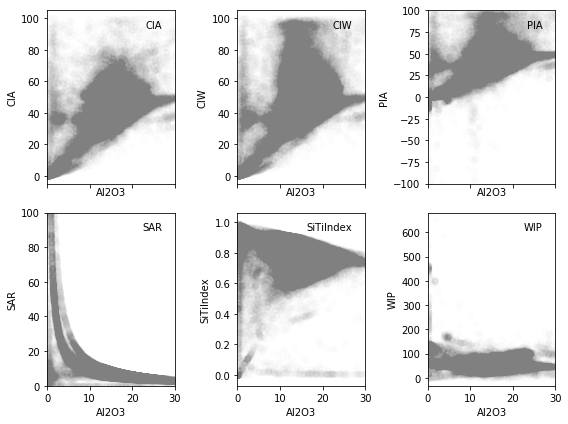

In [7]:
alteration_index_functions = [CIA, CIW, PIA, SAR, SiTiIndex, WIP]
lenfs = len(alteration_index_functions)
plotswide=3
unit = 2
fig, ax = plt.subplots(lenfs%plotswide+lenfs//plotswide, plotswide,
                       figsize=((1+plotswide) * unit, (1 + lenfs//plotswide) * unit),
                       sharex=True)
ax = ax.flat
xvar = 'Al2O3'
filt = (df.Material == 'IGNEOUS') & (~pd.isnull(df.loc[:, xvar]))
major_components = [i for i in df.columns if i in common_oxides(output='str')]
for ix, f in enumerate(alteration_index_functions):
    fname = f.__name__
    if not fname in df.columns:
        df[fname] = f(to_molecular(df.loc[filt, major_components]))
    
    ax[ix].annotate(fname, xy=(0.9, 0.9), ha='right', xycoords=ax[ix].transAxes)
    ax[ix].scatter(df.loc[filt, xvar], df.loc[filt, fname], alpha=0.01, color='0.5')
    ax[ix].set_xlabel(xvar)
    ax[ix].set_ylabel(fname)
    
ax[2].set_ylim((-100, 100))
ax[3].set_ylim((0, 100))
ax[0].set_xlim((0, 30))
plt.tight_layout()